# mean pooling modelを使ってstackingを実装する

## Mean Pooling model LB:0.468

元Note：https://www.kaggle.com/jcesquiveld/roberta-large-5-fold-single-model-meanpooling
<br>https://www.kaggle.com/jcesquiveld/best-transformer-representations

# Import

In [1]:
# !pip install transformers accelerate datasets

In [2]:
# Imports

import os
import numpy as np
import pandas as pd
import random

from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, logging
logging.set_verbosity_error()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, SequentialSampler, RandomSampler, DataLoader

from tqdm.notebook import tqdm

import gc; gc.enable()
from IPython.display import clear_output

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')


In [3]:
# Definitions

# INPUT_DIR = '/content/drive/MyDrive/CommonLit/input/commonlitreadabilityprize'
INPUT_DIR = '../input/commonlitreadabilityprize'
MODEL_NAME = 'roberta-large'

HIDDEN_SIZE = 1024
NUM_HIDDEN_LAYERS = 24
LAYER_START = 4   # for WeightedLayerPoolingModel

HIDDEN_DIM_FC = 128    # for AttentionPooling

MAX_LENGTH = 300
LR = 2e-5
EPS = 1e-8

SEED = 42

NUM_FOLDS = 5
SEEDS = [113, 71, 17, 43, 37]

EPOCHS = 1#5
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 1#32

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Utilities

# Utility classes and functions

class ContinuousStratifiedKFold(StratifiedKFold):
    def split(selfself, x, y, groups=None):
        num_bins = int(np.floor(1 + np.log2(len(y))))
        bins = pd.cut(y, bins=num_bins, labels=False)
        return super().split(x, bins, groups)
    
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_data_loaders(data, fold):
    
    x_train = data.loc[data.fold != fold, 'excerpt'].tolist()
    y_train = data.loc[data.fold != fold, 'target'].values
    x_val = data.loc[data.fold == fold, 'excerpt'].tolist()
    y_val = data.loc[data.fold == fold, 'target'].values
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    encoded_train = tokenizer.batch_encode_plus(
        x_train, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        padding='max_length', 
        truncation=True,
        max_length=MAX_LENGTH, 
        return_tensors='pt'
    )
    
    encoded_val = tokenizer.batch_encode_plus(
        x_val, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        padding='max_length', 
        truncation=True,
        max_length=MAX_LENGTH, 
        return_tensors='pt'
    )
    
    dataset_train = TensorDataset(
        encoded_train['input_ids'],
        encoded_train['attention_mask'],
        torch.tensor(y_train)
    )
    dataset_val = TensorDataset(
        encoded_val['input_ids'],
        encoded_val['attention_mask'],
        torch.tensor(y_val)
    )
    
    dataloader_train = DataLoader(
        dataset_train,
        sampler = RandomSampler(dataset_train),
        batch_size=TRAIN_BATCH_SIZE
    )

    dataloader_val = DataLoader(
        dataset_val,
        sampler = SequentialSampler(dataset_val),
        batch_size=VAL_BATCH_SIZE
    )

    return dataloader_train, dataloader_val

<h2>Model definitions</h2>

In [5]:
      
        
class MeanPoolingModel(nn.Module):
    
    def __init__(self, model_name):
        super().__init__()
        
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, config=config)
        self.linear = nn.Linear(HIDDEN_SIZE, 1)
        self.loss = nn.MSELoss()
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        outputs = self.model(input_ids, attention_mask)
        last_hidden_state = outputs[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        logits = self.linear(mean_embeddings)
        
        preds = logits.squeeze(-1).squeeze(-1)
        
        if labels is not None:
            loss = self.loss(preds.view(-1).float(), labels.view(-1).float())
            return loss
        else:
            return preds
     

# 評価関数

In [6]:
def eval_mse(model, data_loader):
    """Evaluates the mean squared error of the |model| on |data_loader|"""
    model.eval()            
    mse_sum = 0

    with torch.no_grad():
        for batch_num, (input_ids, attention_mask, target) in enumerate(data_loader):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)                        
            target = target.to(DEVICE)           
            
            pred = model(input_ids, attention_mask)                       

            mse_sum += nn.MSELoss(reduction="sum")(pred.flatten(), target).item()
                

    return mse_sum / len(data_loader.dataset)

<h2>Read data and create folds</h2>

For the results to be reproducible, I create the same folds I'm using in the competition.

In [7]:
# Read competition data
data = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))

# Create stratified folds
kf = ContinuousStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for f, (t_, v_) in enumerate(kf.split(data, data.target)):
    data.loc[v_, 'fold'] = f
data['fold'] = data['fold'].astype(int)


In [8]:
### nishipyに合わせてtarget and std = 0を消す
data.drop(data[(data.target == 0) & (data.standard_error == 0)].index,
              inplace=True)
data.reset_index(drop=True, inplace=True)

<h2>Training and evaluation</h2>

In [9]:
# !mkdir /content/drive/MyDrive/CommonLit/output/stacking

In [10]:
def evaluate(model, val_dataloader):

    model.eval()
    
    loss_val_total = 0
    
    for batch in val_dataloader:
        
        batch = tuple(b.to(DEVICE) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            loss = model(**inputs)
            
        loss_val_total += loss.item()

    loss_val_avg = loss_val_total/len(val_dataloader) 
            
    return loss_val_avg


def train(model, train_dataloader, val_dataloader):
    
    optimizer = AdamW(model.parameters(), lr = LR, eps = EPS)

    print("len(train_dataloader) = ",len(train_dataloader))
    
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
                                                num_training_steps=len(train_dataloader) * EPOCHS)
    best_val_loss = 1
    best_rmse = 10
    model.train()
                                                
    for epoch in range(EPOCHS):
    
        loss_train_total = 0
        for batch in tqdm(train_dataloader):
    
            model.zero_grad()
            batch = tuple(b.to(DEVICE) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }
        
            loss = model(**inputs)
            # print('loss  ',loss)
            loss_train_total += loss.item()
        
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        loss_train_avg = loss_train_total / len(train_dataloader)
        
        val_rmse = math.sqrt(eval_mse(model, val_dataloader))
        loss_val_avg = evaluate(model, val_dataloader)
        print(f'epoch:{epoch+1}/{EPOCHS} train loss={loss_train_avg}  val loss={loss_val_avg}  val rmse = {val_rmse}')

        if val_rmse < best_rmse:
            print("best rmse is Updated! ",best_rmse , " to ", val_rmse)
            best_rmse = val_rmse
            torch.save(model.state_dict(),f"./model_fold{fold}.pth")
#             torch.save(model.state_dict(),f"/content/drive/MyDrive/CommonLit/output/stacking/model_fold{fold}.pth")
   
        # if loss_val_avg < best_val_loss:
        #     print("best val loss is Updated! ",best_val_loss , " to ", loss_val_avg)
        #     best_val_loss = loss_val_avg
        #     torch.save(model.state_dict(),f"model_fold{fold}.pth")
            
    return best_val_loss

## Dataset


In [11]:

from torch.utils.data import DataLoader
from torch.utils.data import Dataset


def predict(model, data_loader):
    """Returns an np.array with predictions of the |model| on |data_loader|"""
    model.eval()

    result = np.zeros(len(data_loader.dataset))    
    index = 0
    
    with torch.no_grad():
        for batch_num, (input_ids, attention_mask) in enumerate(data_loader):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
                        
            pred = model(input_ids, attention_mask)                        

            result[index : index + pred.shape[0]] = pred.flatten().to("cpu")
            index += pred.shape[0]

    return result


class LitDataset(Dataset):
    def __init__(self, df, inference_only=False):
        super().__init__()

        self.df = df        
        self.inference_only = inference_only
        self.text = df.excerpt.tolist()
        #self.text = [text.replace("\n", " ") for text in self.text]
        
        if not self.inference_only:
            self.target = torch.tensor(df.target.values, dtype=torch.float32)        
    
        self.encoded = tokenizer.batch_encode_plus(
            self.text,
            padding = 'max_length',            
            max_length = MAX_LEN,
            truncation = True,
            return_attention_mask=True
        )        
 

    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, index):        
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        
        if self.inference_only:
            return (input_ids, attention_mask)            
        else:
            target = self.target[index]
            return (input_ids, attention_mask, target)

# Stacking実装パート
## Fold毎の予測結果を出力

In [12]:
# test_dataset = LitDataset(test_df, inference_only=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
#                          drop_last=False, shuffle=False, num_workers=2)

pred = []
pred0 = []
pred1 = []
pred2 = []
pred3 = []
pred4 = []

FOLDS = 5
EPOCHS = 3
BATCH = 8
MAX_LEN = 248
TOKENIZER_PATH = "../input/roberta-large-20210712191259-mlm/clrp_roberta_large"

# all_predictions = np.zeros((5, len(x_val)))

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)

for fold in range(FOLDS):

    x_train = data.loc[data.fold != fold, 'excerpt'].tolist()
    y_train = data.loc[data.fold != fold, 'target'].values
    # x_val = data.loc[data.fold == fold, 'excerpt'].tolist()
    # x_val = data.loc[data.fold == fold, 'excerpt']
    x_val = data[['id','excerpt']].loc[data.fold == fold]
    y_val = data.loc[data.fold == fold, 'target'].values

    

    test_dataset = LitDataset(x_val, inference_only=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH,
                         drop_last=False, shuffle=False, num_workers=2)

    print(f'*** fold = {fold} ***')

    #CHANGEME
    model_path = f"../input/robertalargemeanpooling/model_fold{fold}.pth"
    print(f"\nUsing {model_path}")
    
    # model = LitModel()
    model = MeanPoolingModel(MODEL_NAME)
    model.load_state_dict(torch.load(model_path))  
    model.to(DEVICE)
    
    if fold == 0:
        pred0 = predict(model, test_loader)
        x_fold0 = x_val.copy()
        x_fold0['meanpooling pred'] = pred0
        print(f"pred{fold} len : ",len(pred0))

    elif fold == 1:
        
        pred1 = predict(model, test_loader)
        x_fold1 = x_val.copy()
        x_fold1['meanpooling pred'] = pred1
        print(f"pred{fold} len : ",len(pred1))

    elif fold == 2:
        
        pred2 = predict(model, test_loader)
        x_fold2 = x_val.copy()
        x_fold2['meanpooling pred'] = pred2
        print(f"pred{fold} len : ",len(pred2))

    elif fold == 3:
        
        pred3 = predict(model, test_loader)
        x_fold3 = x_val.copy()
        x_fold3['meanpooling pred'] = pred3
        print(f"pred{fold} len : ",len(pred3))

    elif fold == 4:
        
        pred4 = predict(model, test_loader)
        x_fold4 = x_val.copy()
        x_fold4['meanpooling pred'] = pred4
        print(f"pred{fold} len : ",len(pred4))

    # pred = predict(model, test_loader)
    # x_val['pred'] = pred
    
    del model
    gc.collect()


*** fold = 0 ***

Using ../input/robertalargemeanpooling/model_fold0.pth


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

pred0 len :  567
*** fold = 1 ***

Using ../input/robertalargemeanpooling/model_fold1.pth
pred1 len :  567
*** fold = 2 ***

Using ../input/robertalargemeanpooling/model_fold2.pth
pred2 len :  567
*** fold = 3 ***

Using ../input/robertalargemeanpooling/model_fold3.pth
pred3 len :  566
*** fold = 4 ***

Using ../input/robertalargemeanpooling/model_fold4.pth
pred4 len :  566


# 元データにmerge

In [13]:
df_concat = pd.concat([x_fold0, x_fold1, x_fold2, x_fold3, x_fold4])
df_meanpooling = pd.merge(data, df_concat, on='id')

df_meanpooling = df_meanpooling.drop(['url_legal','license','standard_error','fold','excerpt_y'],axis = 1).rename({'excerpt_x':'excerpt'},axis=1)
df_meanpooling

,id,excerpt,target,meanpooling pred
0,c12129c31,When the young people returned to the ballroom...,-0.340259,-0.207184
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,-0.272321
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,-0.543892
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,-1.566886
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,-0.133207
...,...,...,...,...
2828,25ca8f498,When you think of dinosaurs and where they liv...,1.711390,0.639129
2829,2c26db523,So what is a solid? Solids are usually hard be...,0.189476,0.250395
2830,cd19e2350,The second state of matter we will discuss is ...,0.255209,-0.384784
2831,15e2e9e7a,Solids are shapes that you can actually touch....,-0.215279,-1.254781


# pred と targetの相関を図示

<AxesSubplot:xlabel='meanpooling pred', ylabel='target'>

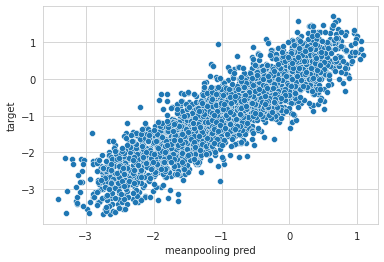

In [14]:
import seaborn as sns

sns.scatterplot(data=df_meanpooling, x='meanpooling pred', y='target')

まぁまぁきれいな相関

# csv出力

In [15]:
df_meanpooling.to_csv('meanpooling_stackingdata.csv',index=False)